In [30]:
import pandas as pd
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy import stats
from scipy.stats import skew
from scipy.stats import mode
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [31]:
train=pd.read_csv(r"C:\\Users\\Pranjal\Desktop\data\carInsurance_train.csv")
test=pd.read_csv(r"C:\\Users\\Pranjal\Desktop\data\carInsurance_test.csv")

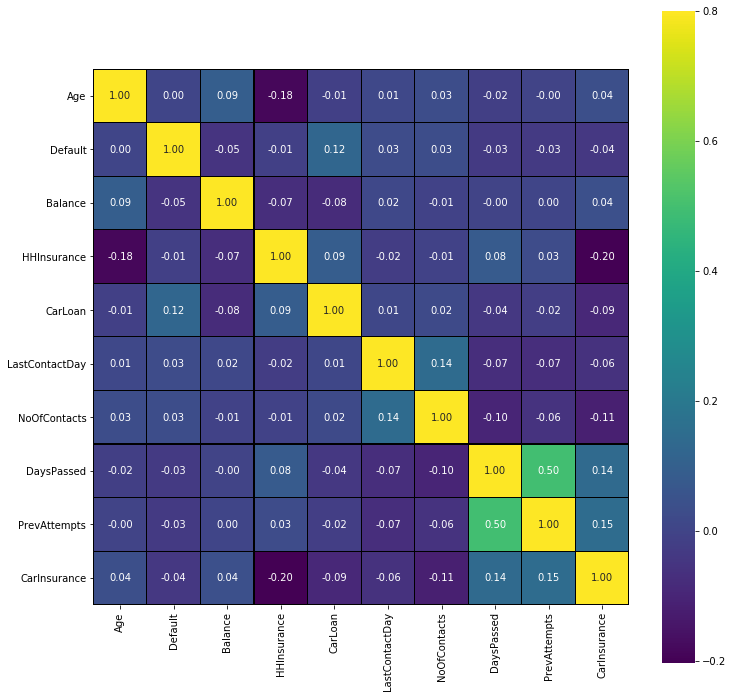

In [32]:
colormap=plt.cm.viridis
cor=train.corr()
cor=cor.drop(['Id'],axis=1).drop(['Id'],axis=0)
plt.figure(figsize=(12,12))
sns.heatmap(cor,vmax=0.8,cmap=colormap,annot=True,fmt='.2f',square=True,annot_kws={'size':10},linecolor='black',linewidths=0.1)

C:\Users\Pranjal\anaconda3\lib\site-packages\seaborn\axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


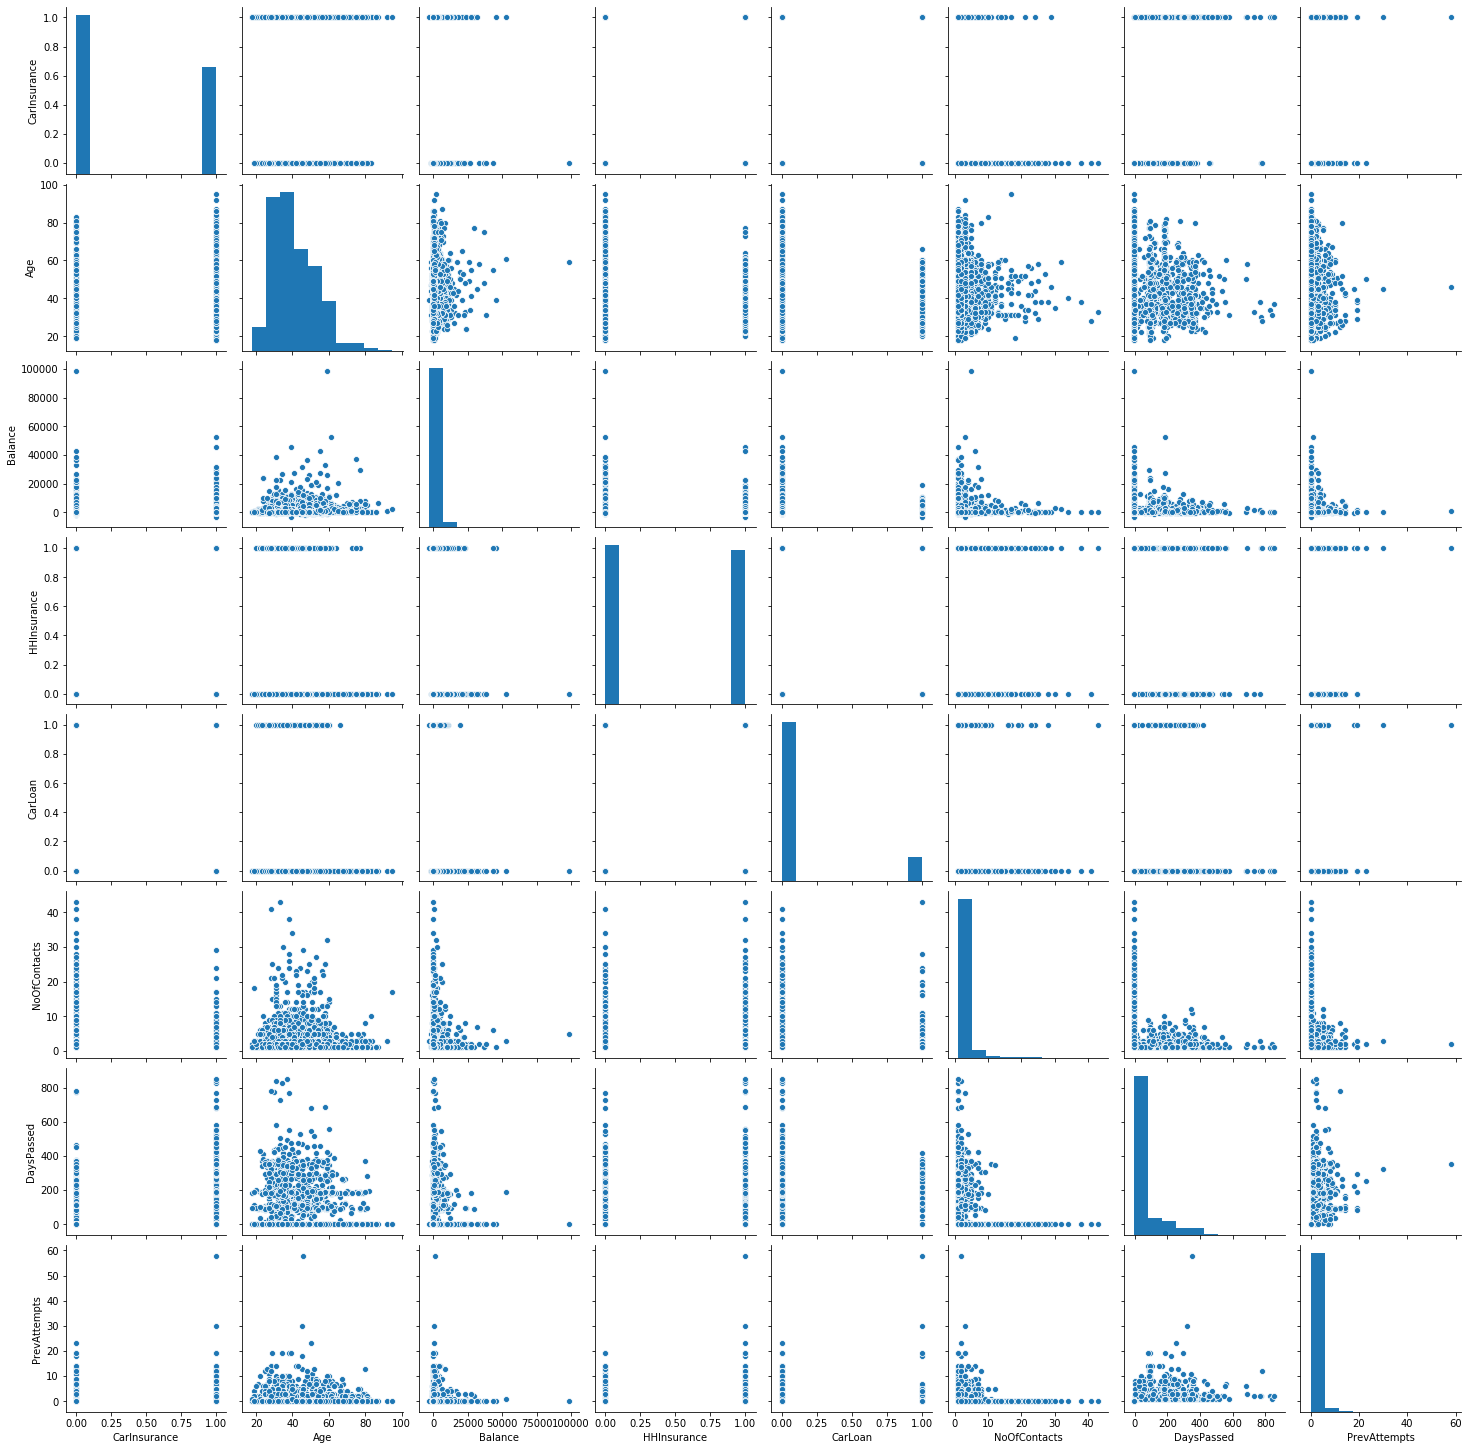

In [33]:
# Next, pair plot some important features
imp_feats = ['CarInsurance','Age','Balance','HHInsurance', 'CarLoan','NoOfContacts','DaysPassed','PrevAttempts']
sns.pairplot(train[imp_feats], palette = "viridis", size=2.5)
plt.show()

C:\Users\Pranjal\anaconda3\lib\site-packages\seaborn\axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\Pranjal\anaconda3\lib\site-packages\seaborn\axisgrid.py:851: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  func(*plot_args, **plot_kwargs)


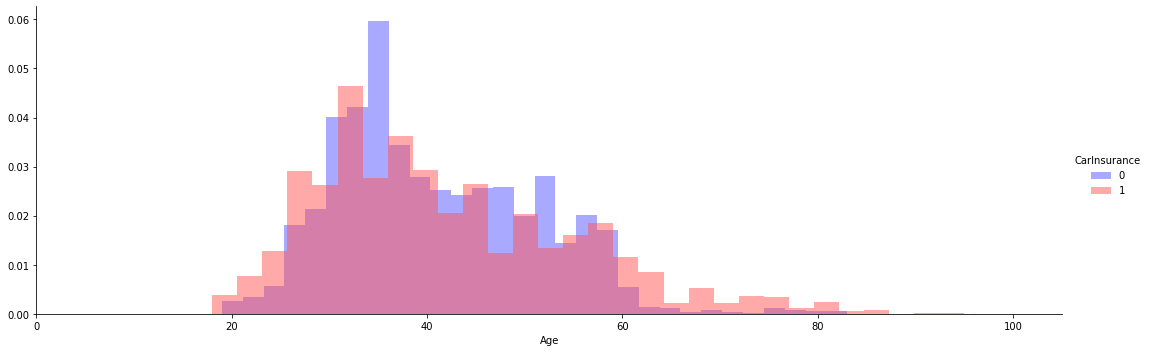

In [34]:
# Take a further look at Age
facet = sns.FacetGrid(train, hue='CarInsurance',size=5,aspect=3,palette='seismic')
facet.map(plt.hist,'Age',bins=30,alpha=0.5,normed=True)
facet.set(xlim=(0,train.Age.max()+10))
facet.add_legend()

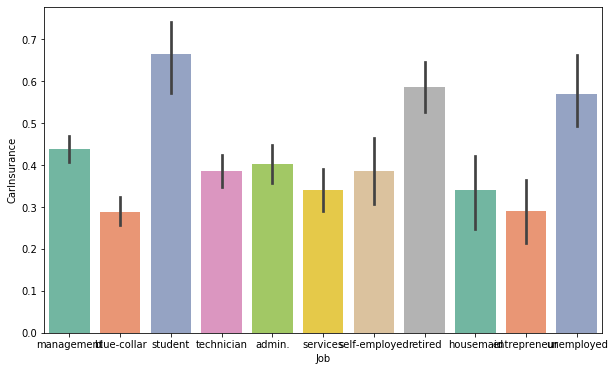

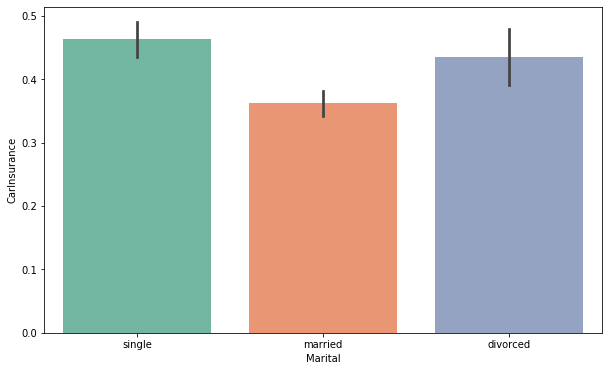

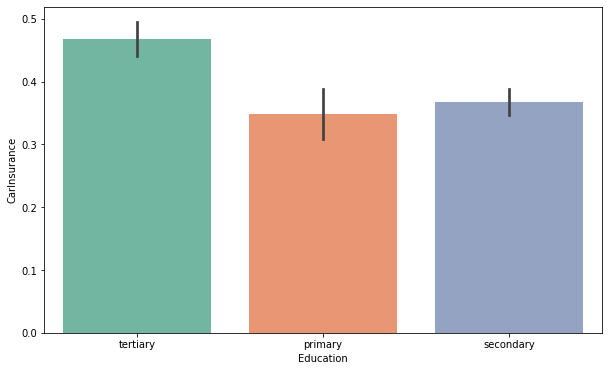

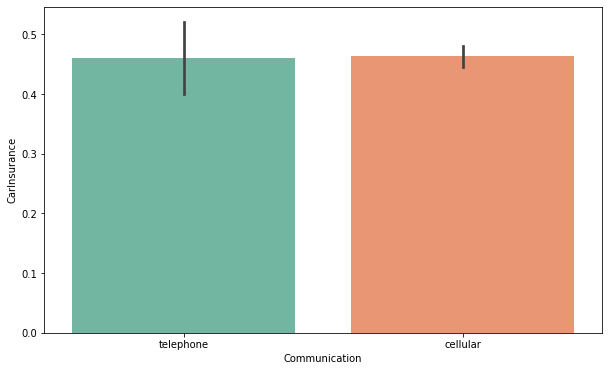

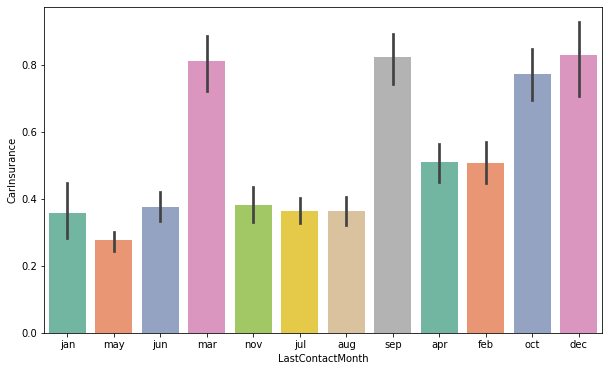

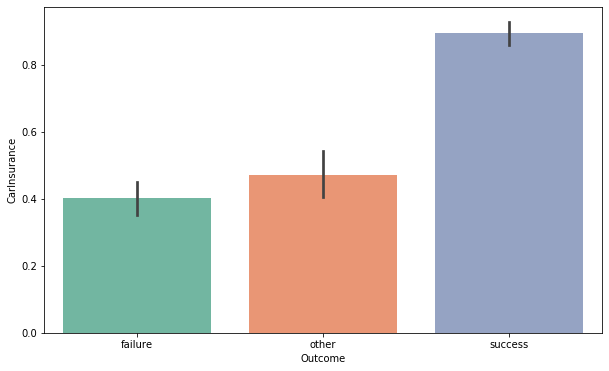

In [35]:
cat_feats=train.select_dtypes(include=['object']).columns
plt_feats = cat_feats[(cat_feats!= 'CallStart') & (cat_feats!='CallEnd')]
for feature in plt_feats:
    plt.figure(figsize=(10,6))
    sns.barplot(feature,'CarInsurance', data=train,palette='Set2')

In [36]:
# From the pairplot, we can see there is an outlier with extreme high balance. Drop that obs here.
train[train['Balance']>80000]
train = train.drop(train[train.index==1742].index)

In [37]:
all=pd.concat([train,test],keys=('train','test'))
all.drop(['CarInsurance','Id'],axis=1,inplace=True)
print(all.shape)

(4999, 17)


In [38]:
total = all.isnull().sum()
pct = total/all.isnull().count()
NAs = pd.concat([total,pct],axis=1,keys=('Total','Pct'))
NAs[NAs.Total>0].sort_values(by='Total',ascending=False)

,Total,Pct
Outcome,3798,0.759752
Communication,1123,0.224645
Education,216,0.043209
Job,24,0.004801


In [39]:
all_df = all.copy()

# Fill missing outcome as not in previous campaign
all_df[all_df['DaysPassed']==-1].count()
all_df.loc[all_df['DaysPassed']==-1,'Outcome']='NoPrev'

# Fill missing communication with none 
all_df['Communication'].value_counts()
all_df['Communication'].fillna('None',inplace=True)

# Fill missing education with the most common education level by job type
all_df['Education'].value_counts()

# Create job-education level mode mapping
edu_mode=[]
job_types = all_df.Job.value_counts().index
for job in job_types:
    mode = all_df[all_df.Job==job]['Education'].value_counts().nlargest(1).index
    edu_mode = np.append(edu_mode,mode)
edu_map=pd.Series(edu_mode,index=all_df.Job.value_counts().index)

# Apply the mapping to missing eductaion obs
for j in job_types:
    all_df.loc[(all_df['Education'].isnull()) & (all_df['Job']==j),'Education'] = edu_map.loc[edu_map.index==j][0]
all_df['Education'].fillna('None',inplace=True)

# Fill missing job with none
all_df['Job'].fillna('None',inplace=True)

# Double check if there is still any missing value
all_df.isnull().sum().sum()

0

Feature Engineering

In [40]:
# Create age group based on age bands
all_df['AgeBand']=pd.cut(all_df['Age'],5)
print(all_df['AgeBand'].value_counts())

all_df.loc[(all_df['Age']>=17) & (all_df['Age']<34),'AgeBin'] = 1
all_df.loc[(all_df['Age']>=34) & (all_df['Age']<49),'AgeBin'] = 2
all_df.loc[(all_df['Age']>=49) & (all_df['Age']<65),'AgeBin'] = 3
all_df.loc[(all_df['Age']>=65) & (all_df['Age']<80),'AgeBin'] = 4
all_df.loc[(all_df['Age']>=80) & (all_df['Age']<96),'AgeBin'] = 5
all_df['AgeBin'] = all_df['AgeBin'].astype(int)

# Create balance groups
all_df['BalanceBand']=pd.cut(all_df['Balance'],5)
print(all_df['BalanceBand'].value_counts())
all_df.loc[(all_df['Balance']>=-3200) & (all_df['Balance']<17237),'BalanceBin'] = 1
all_df.loc[(all_df['Balance']>=17237) & (all_df['Balance']<37532),'BalanceBin'] = 2
all_df.loc[(all_df['Balance']>=37532) & (all_df['Balance']<57827),'BalanceBin'] = 3
all_df.loc[(all_df['Balance']>=57827) & (all_df['Balance']<78122),'BalanceBin'] = 4
all_df.loc[(all_df['Balance']>=78122) & (all_df['Balance']<98418),'BalanceBin'] = 5
all_df['BalanceBin'] = all_df['BalanceBin'].astype(int)

all_df = all_df.drop(['AgeBand','BalanceBand','Age','Balance'],axis=1)

# Convert education level to numeric 
all_df['Education'] = all_df['Education'].replace({'None':0,'primary':1,'secondary':2,'tertiary':3})

(33.4, 48.8]      2184
(17.923, 33.4]    1508
(48.8, 64.2]      1147
(64.2, 79.6]       133
(79.6, 95.0]        27
Name: AgeBand, dtype: int64
(-3113.645, 8071.0]    4847
(8071.0, 19200.0]       123
(19200.0, 30329.0]       20
(30329.0, 41458.0]        5
(41458.0, 52587.0]        4
Name: BalanceBand, dtype: int64


In [41]:
# Get call length
all_df['CallEnd'] = pd.to_datetime(all_df['CallEnd'])
all_df['CallStart'] = pd.to_datetime(all_df['CallStart'])
all_df['CallLength'] = ((all_df['CallEnd'] - all_df['CallStart'])/np.timedelta64(1,'m')).astype(float)
all_df['CallLenBand']=pd.cut(all_df['CallLength'],5)
print(all_df['CallLenBand'].value_counts())

# Create call length bins
all_df.loc[(all_df['CallLength']>= 0) & (all_df['CallLength']<11),'CallLengthBin'] = 1
all_df.loc[(all_df['CallLength']>=11) & (all_df['CallLength']<22),'CallLengthBin'] = 2
all_df.loc[(all_df['CallLength']>=22) & (all_df['CallLength']<33),'CallLengthBin'] = 3
all_df.loc[(all_df['CallLength']>=33) & (all_df['CallLength']<44),'CallLengthBin'] = 4
all_df.loc[(all_df['CallLength']>=44) & (all_df['CallLength']<55),'CallLengthBin'] = 5
all_df['CallLengthBin'] = all_df['CallLengthBin'].astype(int)
all_df = all_df.drop('CallLenBand',axis=1)

# Get call start hour
all_df['CallStartHour'] = all_df['CallStart'].dt.hour
print(all_df[['CallStart','CallEnd','CallLength','CallStartHour']].head())

# Get workday of last contact based on call day and month, assuming the year is 2016
all_df['LastContactDate'] = all_df.apply(lambda x:datetime.datetime.strptime("%s %s %s" %(2016,x['LastContactMonth'],x['LastContactDay']),"%Y %b %d"),axis=1)
all_df['LastContactWkd'] = all_df['LastContactDate'].dt.weekday
all_df['LastContactWkd'].value_counts()
all_df['LastContactMon'] = all_df['LastContactDate'].dt.month
all_df = all_df.drop('LastContactMonth',axis=1)

# Get week of last contact
all_df['LastContactWk'] = all_df['LastContactDate'].dt.week

# Get num of week in a month. There might be easier ways to do this, I will keep exploring. 
MonWk = all_df.groupby(['LastContactWk','LastContactMon'])['Education'].count().reset_index()
MonWk = MonWk.drop('Education',axis=1)
MonWk['LastContactWkNum']=0
for m in range(1,13):
    k=0
    for i,row in MonWk.iterrows():
        if row['LastContactMon']== m:
            k=k+1
            row['LastContactWkNum']=k
            
def get_num_of_week(df):
    for i,row in MonWk.iterrows():
        if (df['LastContactWk']== row['LastContactWk']) & (df['LastContactMon']== row['LastContactMon']):
            return row['LastContactWkNum']

all_df['LastContactWkNum'] = all_df.apply(lambda x: get_num_of_week(x),axis=1)
print(all_df[['LastContactWkNum','LastContactWk','LastContactMon']].head(10))


(0.0292, 10.91]     4274
(10.91, 21.737]      601
(21.737, 32.563]     104
(32.563, 43.39]       15
(43.39, 54.217]        5
Name: CallLenBand, dtype: int64
                  CallStart             CallEnd  CallLength  CallStartHour
train 0 2020-07-23 13:45:20 2020-07-23 13:46:30    1.166667             13
      1 2020-07-23 14:49:03 2020-07-23 14:52:08    3.083333             14
      2 2020-07-23 16:30:24 2020-07-23 16:36:04    5.666667             16
      3 2020-07-23 12:06:43 2020-07-23 12:20:22   13.650000             12
      4 2020-07-23 14:35:44 2020-07-23 14:38:56    3.200000             14
         LastContactWkNum  LastContactWk  LastContactMon
train 0                 4              4               1
      1                 4             21               5
      2                 1             22               6
      3                 2             19               5
      4                 1             22               6
      5                 3             20           

Assembling Final dataset

In [42]:
# Spilt numeric and categorical features
cat_feats = all_df.select_dtypes(include=['object']).columns
num_feats = all_df.select_dtypes(include=['float64','int64']).columns
num_df = all_df[num_feats]
cat_df = all_df[cat_feats]
print('There are %d numeric features and %d categorical features\n' %(len(num_feats),len(cat_feats)))
print('Numeric features:\n',num_feats.values)
print('Categorical features:\n',cat_feats.values)

There are 14 numeric features and 4 categorical features

Numeric features:
 ['Education' 'Default' 'HHInsurance' 'CarLoan' 'LastContactDay'
 'NoOfContacts' 'DaysPassed' 'PrevAttempts' 'CallLength' 'CallStartHour'
 'LastContactWkd' 'LastContactMon' 'LastContactWk' 'LastContactWkNum']
Categorical features:
 ['Job' 'Marital' 'Communication' 'Outcome']


In [43]:
# One hot encoding
cat_df = pd.get_dummies(cat_df)

In [44]:
# Merge all features
all_data = pd.concat([num_df,cat_df],axis=1)

In [45]:
# Split train and test
idx=pd.IndexSlice
train_df=all_data.loc[idx[['train',],:]]
test_df=all_data.loc[idx[['test',],:]]
train_label=train['CarInsurance']
print(train_df.shape)
print(len(train_label))
print(test_df.shape)

(3999, 36)
3999
(1000, 36)


In [51]:
# Train test split
x_train, x_test, y_train, y_test = train_test_split(train_df,train_label,test_size = 0.3,random_state=3)
from sklearn.model_selection import GridSearchCV

Modeling

In [52]:
# Create a model fitting function
def model_fit(model,feature_imp=True,cv=5):

    # model fit   
    clf = model.fit(x_train,y_train)
    
    # model prediction     
    y_pred = clf.predict(x_test)
    
    # model report     
    cm = confusion_matrix(y_test,y_pred)
    plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

    print('\n--- Train Set -----------------------------')
    print('Accuracy: %.5f +/- %.4f' % (np.mean(cross_val_score(clf,x_train,y_train,cv=cv)),np.std(cross_val_score(clf,x_train,y_train,cv=cv))))
    print('AUC: %.5f +/- %.4f' % (np.mean(cross_val_score(clf,x_train,y_train,cv=cv,scoring='roc_auc')),np.std(cross_val_score(clf,x_train,y_train,cv=cv,scoring='roc_auc'))))
    print('\n--- Validation Set -----------------------------')    
    print('Accuracy: %.5f +/- %.4f' % (np.mean(cross_val_score(clf,x_test,y_test,cv=cv)),np.std(cross_val_score(clf,x_test,y_test,cv=cv))))
    print('AUC: %.5f +/- %.4f' % (np.mean(cross_val_score(clf,x_test,y_test,cv=cv,scoring='roc_auc')),np.std(cross_val_score(clf,x_test,y_test,cv=cv,scoring='roc_auc'))))
    print('-----------------------------------------------') 

    # feature importance 
    if feature_imp:
        feat_imp = pd.Series(clf.feature_importances_,index=all_data.columns)
        feat_imp = feat_imp.nlargest(15).sort_values()
        plt.figure()
        feat_imp.plot(kind="barh",figsize=(6,8),title="Most Important Features")

In [53]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = ['Success','Failure']

In [54]:
def get_best_model(estimator, params_grid={}):
    
    model = GridSearchCV(estimator = estimator,param_grid = params_grid,cv=3, scoring="accuracy", n_jobs= -1)
    model.fit(x_train,y_train)
    print('\n--- Best Parameters -----------------------------')
    print(model.best_params_)
    print('\n--- Best Model -----------------------------')
    best_model = model.best_estimator_
    print(best_model)
    return best_model


--- Best Parameters -----------------------------
{'max_depth': 10, 'max_features': 13, 'min_samples_split': 11, 'n_estimators': 100}

--- Best Model -----------------------------
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features=13,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=11,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)

--- Train Set -----------------------------
Accuracy: 0.84888 +/- 0.0085
AUC: 0.92495 +/- 0.0084

--- Validation Set -----------------------------
Accuracy: 0.81750 +/- 0.0174
AUC: 0.90742 +/- 0.0082
-----------------------------------------------


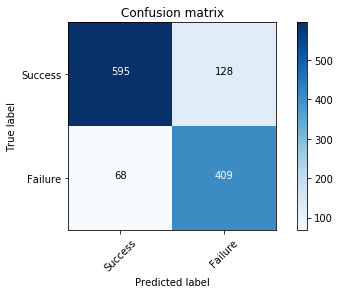

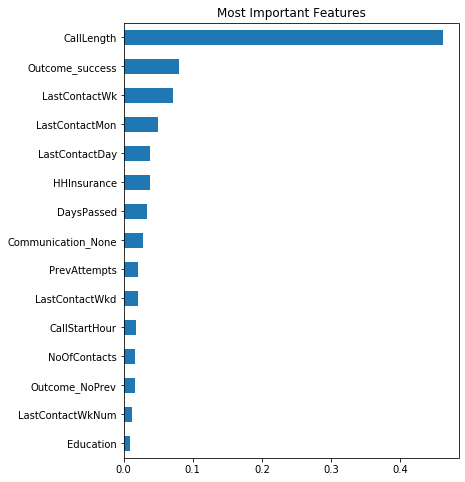

In [55]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=3)
parameters={'n_estimators':[100],
            'max_depth':[10],
            'max_features':[13,14],
            'min_samples_split':[11]}
clf_rf= get_best_model(rf,parameters)
model_fit(model=clf_rf, feature_imp=True)